In [1]:
import chess
import chess.pgn
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

### Game2vec
- This function provides a vector representation of a given chess game

In [2]:
# From chess_utils

def board_to_vec(board):
    '''
        Given a chess.Board return a vector of length 64
        representing the piece / lack of piece at a given square.
    '''
    vec = np.zeros((64), dtype=int)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is not None:
            if piece.color == chess.WHITE:
                vec[square] = piece.piece_type
            else:
                vec[square] = -1 * piece.piece_type
    return vec

def game_to_vec(game, moves_limit):
    '''
    Given a chess.Game, return a concatenation of board states
    represented as vectors, as generated by board_to_vec()
    '''
    board = game.board()
    game_as_vec = np.zeros((64 * moves_limit))
    i = 0
    for move in game.mainline_moves():
        if i >= moves_limit:
            break
        board.push(move)
        game_as_vec[(64*i):(64*(i+1))] = board_to_vec(board)
        i += 1
    return game_as_vec

# Tuning KNN hyperparams
- Tuned # moves considered in game vector, $m$, as well as # neighbours considered in kNN, $k$.
- The best performance was found with $m = 35$, $k = 12$
- Note that this assumes $m$ and $k$ are independent

### Loading training data

In [15]:
TRAIN_FILE = '../data/std_train_big.clean.pgn'

train_pgn = open(TRAIN_FILE)
X_train = []
y_train = []
for i in range(1000):
    game = chess.pgn.read_game(train_pgn)
    X_train.append(game)
    y_train.append([int(game.headers['WhiteElo']),int(game.headers['BlackElo'])])


### # Moves considered in vector representation of game

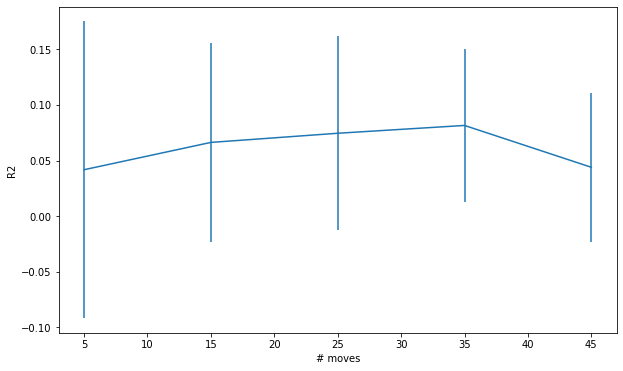

In [8]:
M = range(5, 55, 10)
r2 = []
std = []

for m in M:
    def games_to_opening_vecs(games):
        return np.array(list(map(lambda game: game_to_vec(game, m), games)))

    knn_model = KNeighborsRegressor(n_neighbors = 12, weights = 'uniform', metric='hamming')
    knn_pipe = Pipeline([
        ('Game to vec', FunctionTransformer(games_to_opening_vecs)),
        ('kNN', knn_model)
         ])
    cv_results = cross_validate(knn_pipe, X_train, y_train, cv=10, scoring='r2')
    r2.append(cv_results['test_score'].mean())
    std.append(cv_results['test_score'].std())
    
plt.errorbar(M, r2, yerr=std)
plt.xlabel('# moves')
plt.ylabel('R2')
plt.gcf().set_size_inches(10, 6)
plt.show()

### # Neighbours considered

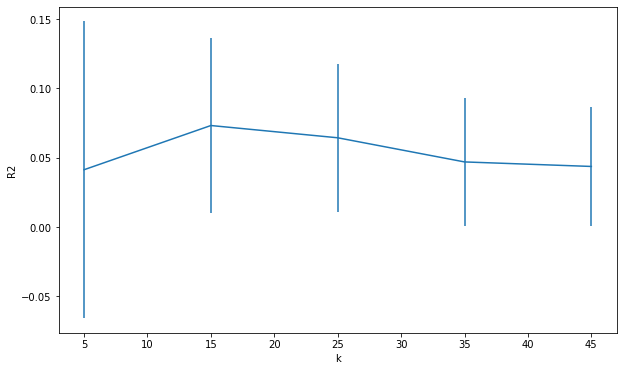

In [9]:
def games_to_opening_vecs(games):
    return np.array(list(map(lambda game: game_to_vec(game, 35), games)))

K = range(5, 50, 10)
r2 = []
std = []

for k in K:
    knn_model = KNeighborsRegressor(n_neighbors = k, weights = 'uniform', metric='hamming')
    knn_pipe = Pipeline([
        ('Game to vec', FunctionTransformer(games_to_opening_vecs)),
        ('kNN', knn_model)
         ])
    cv_results = cross_validate(knn_pipe, X_train, y_train, cv=10, scoring='r2')
    r2.append(cv_results['test_score'].mean())
    std.append(cv_results['test_score'].std())
    
plt.errorbar(K, r2, yerr=std)
plt.xlabel('k')
plt.ylabel('R2')
plt.gcf().set_size_inches(10, 6)
plt.show()

### 3D Cross-Validation Plot

In [32]:
M = np.arange(5, 55, 10)
K = np.arange(5, 50, 10)
r2 = []

for m in M:
    r2_row = []
    for k in K:
        print(m, k)
        def games_to_opening_vecs(games):
            return np.array(list(map(lambda game: game_to_vec(game, m), games)))

        knn_model = KNeighborsRegressor(n_neighbors = k, weights = 'uniform', metric='hamming')
        knn_pipe = Pipeline([
            ('Game to vec', FunctionTransformer(games_to_opening_vecs)),
            ('kNN', knn_model)
             ])
        cv_results = cross_validate(knn_pipe, X_train, y_train, cv=10, scoring='r2')
        r2_row.append(cv_results['test_score'].mean())
    r2.append(r2_row)
    
M, K = np.meshgrid(M, K)
r2 = np.array(r2)

5 5
5 15
5 25
5 35
5 45
15 5
15 15
15 25
15 35
15 45
25 5
25 15
25 25
25 35
25 45
35 5
35 15
35 25
35 35
35 45
45 5
45 15
45 25
45 35
45 45


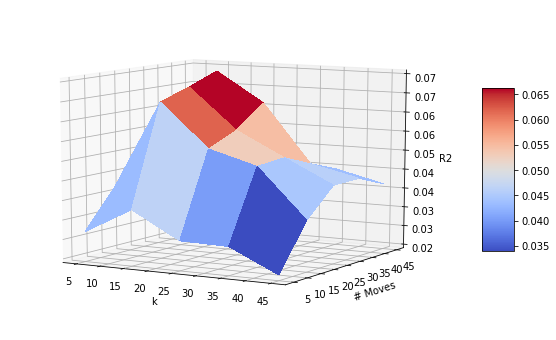

In [33]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(M, K, r2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(elev=10.)
ax.set_xlabel('k')
ax.set_ylabel('# Moves')
ax.set_zlabel('R2')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.gcf().set_size_inches(10, 6)
plt.show()

### Gaussian neighbour weighting

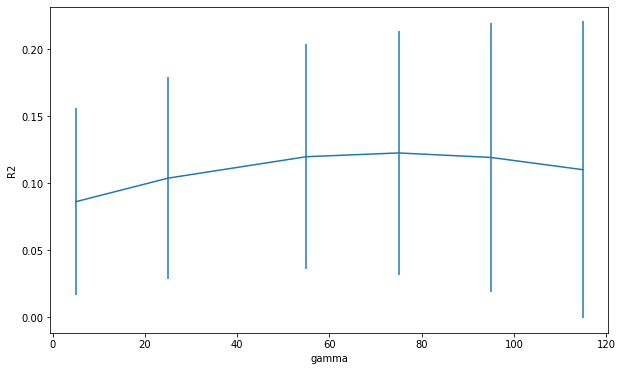

In [30]:
def games_to_opening_vecs(games):
    return np.array(list(map(lambda game: game_to_vec(game, 35), games)))

G = [5, 25, 55, 75, 95, 115]
r2 = []
std = []

for gamma in G:
    def gaussian_kernel(distances):
        weights = np.exp(-gamma * (distances ** 2))
        return weights / np.sum(weights)
    
    knn_model = KNeighborsRegressor(n_neighbors=12, weights=gaussian_kernel, metric='hamming')
    knn_pipe = Pipeline([
        ('Game to vec', FunctionTransformer(games_to_opening_vecs)),
        ('kNN', knn_model)
         ])
    cv_results = cross_validate(knn_pipe, X_train, y_train, cv=10, scoring='r2')
    r2.append(cv_results['test_score'].mean())
    std.append(cv_results['test_score'].std())
    
plt.errorbar(G, r2, yerr=std)
plt.xlabel('gamma')
plt.ylabel('R2')
plt.gcf().set_size_inches(10, 6)
plt.show()

### Addition of gaussian weighting shows significant R2 improvement

In [11]:
def games_to_opening_vecs(games):
    return np.array(list(map(lambda game: game_to_vec(game, 35), games)))

def gaussian_kernel(distances):
    weights = np.exp(-75 * (distances ** 2))
    return weights / np.sum(weights)

knn_model = KNeighborsRegressor(n_neighbors=12, weights=gaussian_kernel, metric='hamming')
knn_pipe = Pipeline([
    ('Game to vec', FunctionTransformer(games_to_opening_vecs)),
    ('kNN', knn_model)
     ])
cv_results = cross_validate(knn_pipe, X_train, y_train, cv=10, scoring='r2')
print('R2 mean:', cv_results['test_score'].mean())
print('R2 std:', cv_results['test_score'].std())

R2 mean: 0.12264890674154176
R2 std: 0.09113921037036403


In [12]:
def games_to_opening_vecs(games):
    return np.array(list(map(lambda game: game_to_vec(game, 35), games)))

knn_model = KNeighborsRegressor(n_neighbors=12, weights='uniform', metric='hamming')
knn_pipe = Pipeline([
    ('Game to vec', FunctionTransformer(games_to_opening_vecs)),
    ('kNN', knn_model)
     ])
cv_results = cross_validate(knn_pipe, X_train, y_train, cv=10, scoring='r2')
print('R2 mean:', cv_results['test_score'].mean())
print('R2 std:', cv_results['test_score'].std())

R2 mean: 0.08149640098599047
R2 std: 0.06837458766472827


# Text features as input

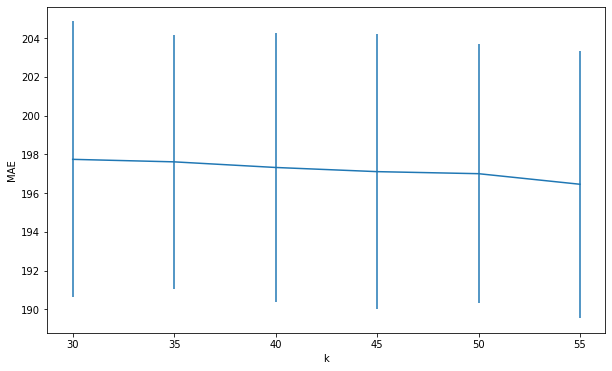

In [65]:
from sklearn.model_selection import cross_validate
import numpy as np
import matplotlib.pyplot as plt

X = np.load('../games_text.npy')
y = np.load('../elos_text.npy')
X = X.astype(np.float64)
y = y.reshape(-1, 1)
y = y.astype(np.float64)

K = range(30, 60, 5)
mae = []
std = []

for k in K:
    model = KNeighborsRegressor(n_neighbors = k, weights = 'uniform', metric='hamming')
    cv_results = cross_validate(model, X, y, cv=10, scoring='neg_mean_absolute_error')
    mae.append(-cv_results['test_score'].mean())
    std.append(cv_results['test_score'].std())
    
plt.errorbar(K, mae, yerr=std)
plt.xlabel('k')
plt.ylabel('MAE')
plt.gcf().set_size_inches(10, 6)
plt.show()

In [59]:
X = np.load('../games_text.npy')
y = np.load('../elos_text.npy')
X = X.astype(np.float64)
y = y.reshape(-1, 1)
y = y.astype(np.float64)

In [60]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate

baseline = DummyRegressor()
cv_results = cross_validate(baseline, X, y, cv=10, scoring='neg_mean_absolute_error')
baseline_fit_time = np.mean(cv_results['fit_time'])
print(f'Fit time: {baseline_fit_time}')
baseline_mae = -np.mean(cv_results['test_score'])
print(f'MAE: {baseline_mae}')

Fit time: 0.010510778427124024
MAE: 196.42374428251125


In [61]:
def mae_ratio(mae):
    return 1 - (mae / baseline_mae)

In [67]:
knn_model = KNeighborsRegressor(n_neighbors = 60, weights = 'uniform', metric='hamming')
cv_results = cross_validate(knn_model, X, y, cv=10, scoring='neg_mean_absolute_error')
knn_fit_time = np.mean(cv_results['fit_time'])
print(f'Fit time: {knn_fit_time}')
knn_mae = -np.mean(cv_results['test_score'])
print(f'MAE: {knn_mae}')
print(f'MAE Ratio: {mae_ratio(knn_mae)}')

Fit time: 0.32084743976593016
MAE: 196.54891279691634
MAE Ratio: -0.0006372371877050309
